In [33]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Connect to the SQLite database
db_path = "../nba_simulation.db"
conn = sqlite3.connect(db_path)

# Query data from the games table
games_query = "SELECT * FROM games"
games_df = pd.read_sql_query(games_query, conn)

# Query data from the player stats table
player_stats_query = "SELECT * FROM player_stats"
player_stats_df = pd.read_sql_query(player_stats_query, conn)

# Query data from the stadium ops table
stadium_ops_query = "SELECT * FROM stadium_ops"
stadium_ops_df = pd.read_sql_query(stadium_ops_query, conn)

# Query data from the playoffs series table
playoffs_query = "SELECT * FROM playoffs_series"
playoffs_df = pd.read_sql_query(playoffs_query, conn)

# Close the connection
conn.close()

# Game Results

/var/folders/1t/hfg6vk0d70lbvbn5vfzq86y80000gn/T/ipykernel_72993/599377589.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_avg_points, x="team1", y="total_avg_points", palette="gist_earth")


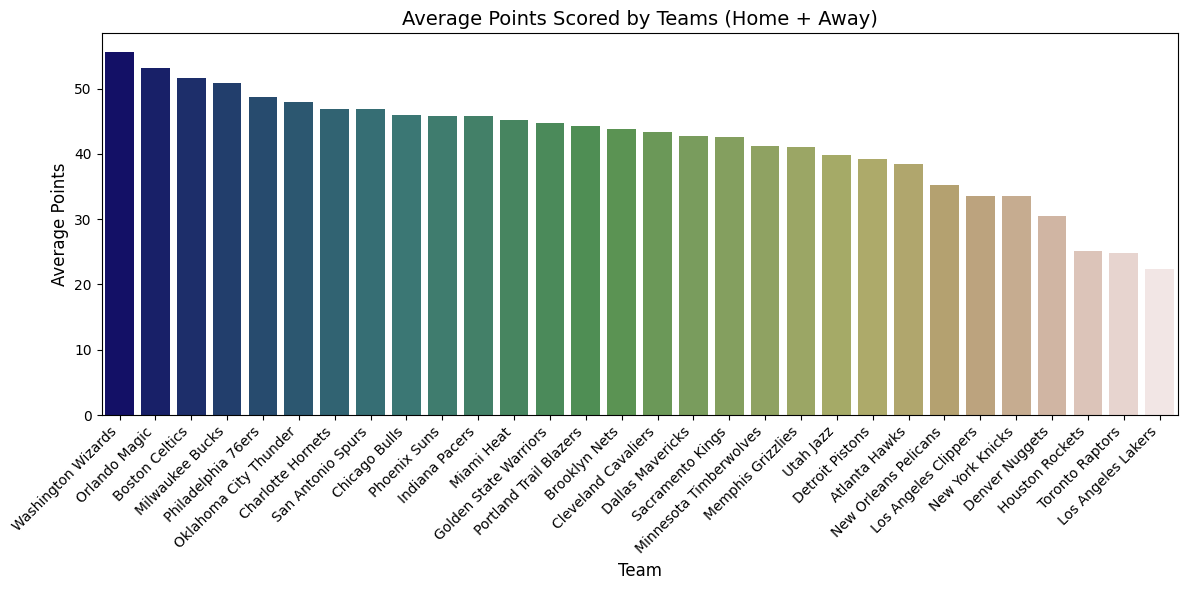

In [35]:
# Group by teams and calculate average points scored
home_team_avg = games_df.groupby("team1")["score1"].mean().reset_index(name="avg_home_points")
away_team_avg = games_df.groupby("team2")["score2"].mean().reset_index(name="avg_away_points")

# Combine home and away averages into a single DataFrame
team_avg_points = pd.merge(home_team_avg, away_team_avg, left_on="team1", right_on="team2", how="outer")
team_avg_points.fillna(0, inplace=True)
team_avg_points["total_avg_points"] = (team_avg_points["avg_home_points"] + team_avg_points["avg_away_points"])/2
team_avg_points = team_avg_points.sort_values(by="total_avg_points", ascending=False)

# Plot average points by team
plt.figure(figsize=(12, 6))
sns.barplot(data=team_avg_points, x="team1", y="total_avg_points", palette="gist_earth")
plt.title("Average Points Scored by Teams (Home + Away)", fontsize=14)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Average Points", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top Players

/var/folders/1t/hfg6vk0d70lbvbn5vfzq86y80000gn/T/ipykernel_72993/704887488.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_players, x="points", y="player_name", palette="rocket")


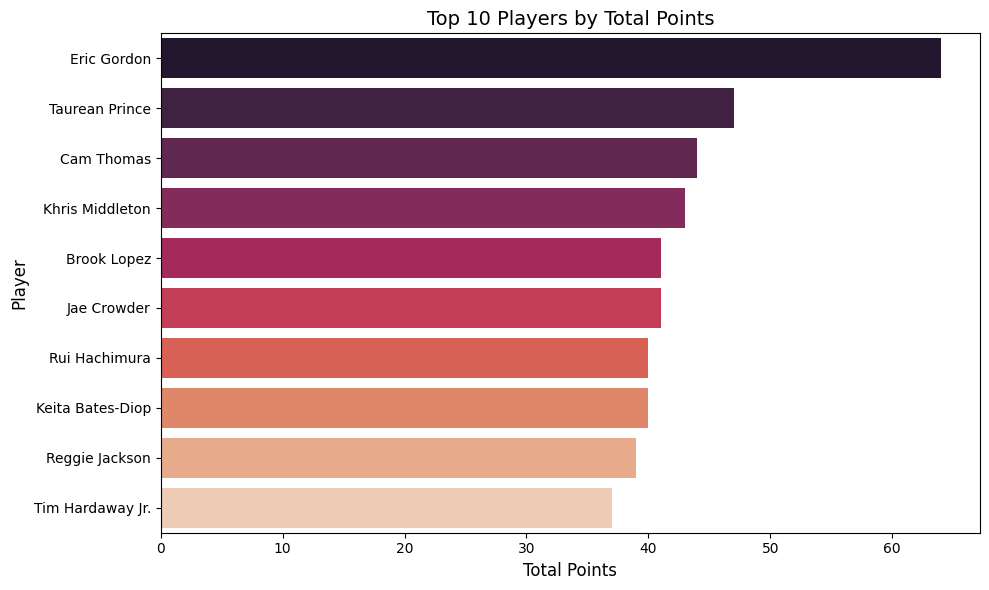

In [36]:
# Top 10 players
top_players = player_stats_df.groupby("player_name")["points"].sum().reset_index()
top_players = top_players.sort_values(by="points", ascending=False).head(10)

# Plot top 10 players by total points
plt.figure(figsize=(10, 6))
sns.barplot(data=top_players, x="points", y="player_name", palette="rocket")
plt.title("Top 10 Players by Total Points", fontsize=14)
plt.xlabel("Total Points", fontsize=12)
plt.ylabel("Player", fontsize=12)
plt.tight_layout()
plt.show()

# Stadium Operations

In [38]:
def extract_entry_types(details_str):
    if isinstance(details_str, str):
        try:
            # Try to parse the string as JSON first (safer)
            import json
            details_dict = json.loads(details_str.replace("'", '"'))
            return details_dict.get('entry_types', {})
        except:
            # Fall back to eval (less safe but can handle Python dict literals)
            try:
                details_dict = eval(details_str)
                return details_dict.get('entry_types', {})
            except:
                pass
    elif isinstance(details_str, dict):
        # If it's already a dictionary, just return the entry_types
        return details_str.get('entry_types', {})
    
    # Default empty dict if all else fails
    return {'VIP': 0, 'Season': 0, 'Regular': 0}

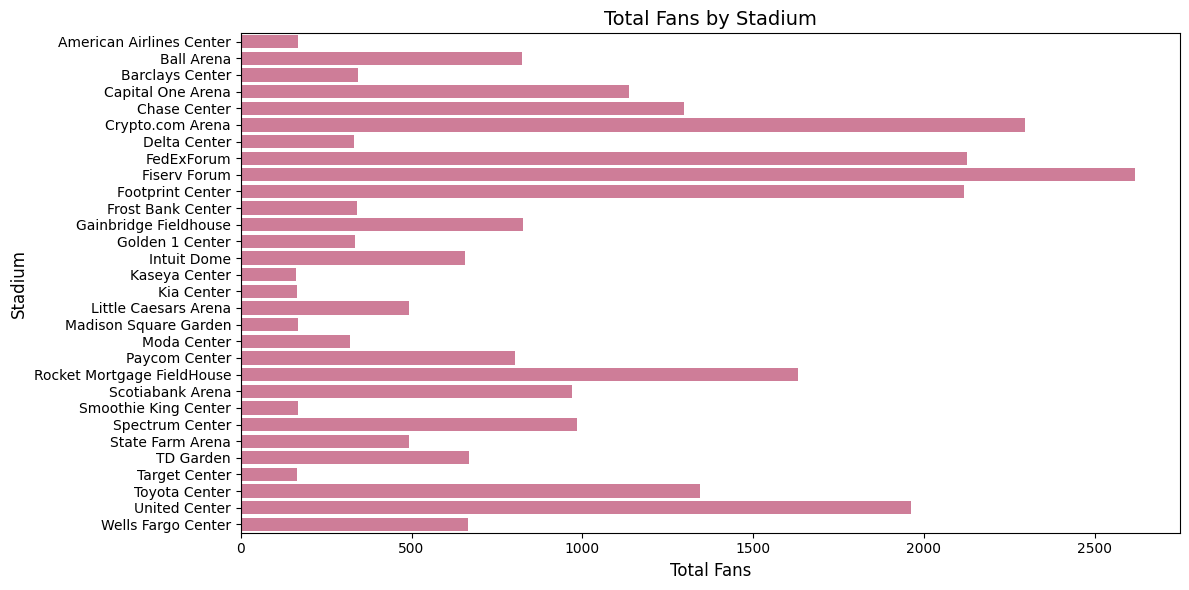

In [39]:
# Process fan entry types
stadium_ops_df["entry_types"] = stadium_ops_df["details"].apply(extract_entry_types)

stadium_ops_df["VIP"] = stadium_ops_df["entry_types"].apply(lambda x: x.get("VIP", 0))
stadium_ops_df["Season"] = stadium_ops_df["entry_types"].apply(lambda x: x.get("Season", 0))
stadium_ops_df["Regular"] = stadium_ops_df["entry_types"].apply(lambda x: x.get("Regular", 0))

# Group by stadium and calculate total fans
stadium_totals = stadium_ops_df.groupby("arena")[["VIP", "Season", "Regular"]].sum()
stadium_totals["Total Fans"] = stadium_totals.sum(axis=1)

# Plot total fans by stadium
plt.figure(figsize=(12, 6))
sns.barplot(data=stadium_totals.reset_index(), x="Total Fans", y="arena", color="palevioletred")
plt.title("Total Fans by Stadium", fontsize=14)
plt.xlabel("Total Fans", fontsize=12)
plt.ylabel("Stadium", fontsize=12)
plt.tight_layout()
plt.show()

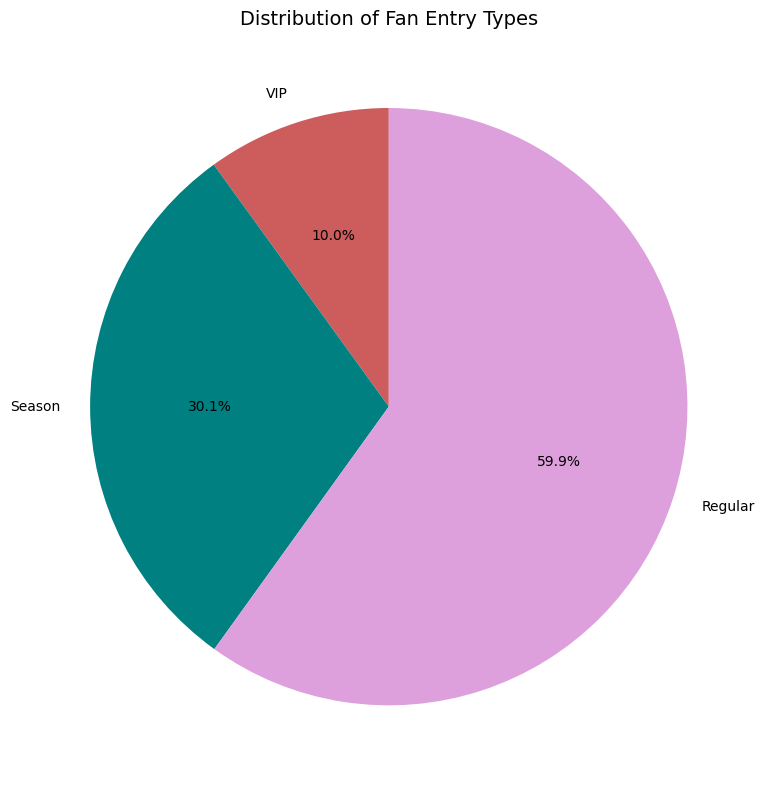

In [40]:
# Plot fan entry types as a pie chart
entry_types_total = stadium_totals[["VIP", "Season", "Regular"]].sum()
plt.figure(figsize=(8, 8))
entry_types_total.plot.pie(autopct="%1.1f%%", startangle=90, colors=["indianred", "teal", "plum"])
plt.title("Distribution of Fan Entry Types", fontsize=14)
plt.ylabel("")  # Remove y-axis label for clarity
plt.tight_layout()
plt.show()

In [41]:
def safe_eval(value):
    if isinstance(value, str):
        try:
            return eval(value)
        except:
            return {}
    elif isinstance(value, dict):
        # If already a dictionary, return as is
        return value
    else:
        # Return empty dict for other types
        return {}

In [42]:
stadium_ops_df["details"] = stadium_ops_df["details"].apply(safe_eval)

# Separate merchandise and concessions
merchandise_df = stadium_ops_df[stadium_ops_df["operation_type"] == "merchandise"]
concessions_df = stadium_ops_df[stadium_ops_df["operation_type"] == "concessions"]

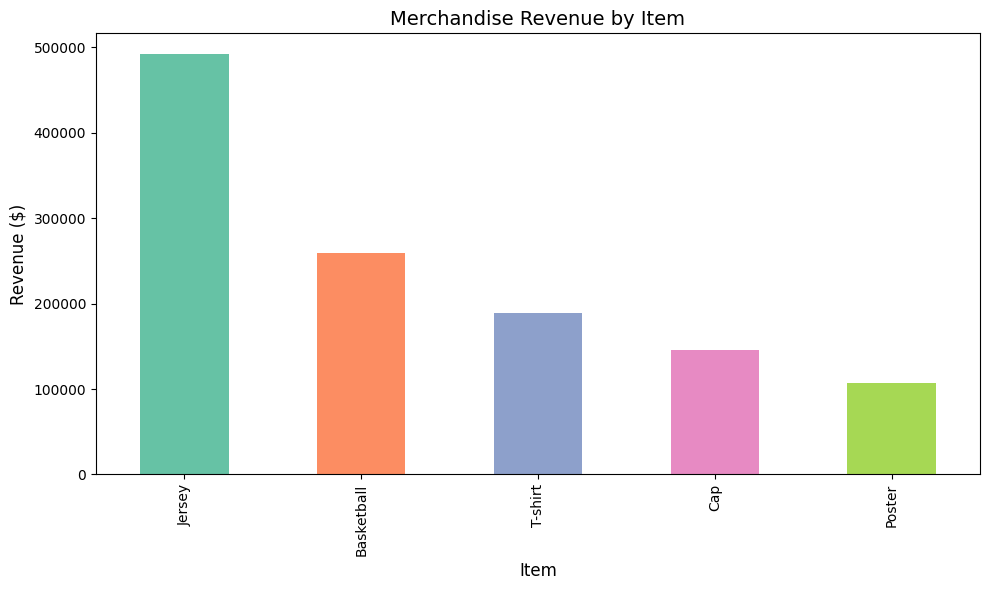

In [43]:
# Merchandise: Total Revenue by Item
merchandise_revenue = merchandise_df["details"].apply(lambda x: x["revenue"])
total_merchandise_revenue = pd.DataFrame(merchandise_revenue.tolist()).sum()
plt.figure(figsize=(10, 6))
total_merchandise_revenue.sort_values(ascending=False).plot(kind="bar", color=plt.cm.Set2.colors)
plt.title("Merchandise Revenue by Item", fontsize=14)
plt.xlabel("Item", fontsize=12)
plt.ylabel("Revenue ($)", fontsize=12)
plt.tight_layout()
plt.show()

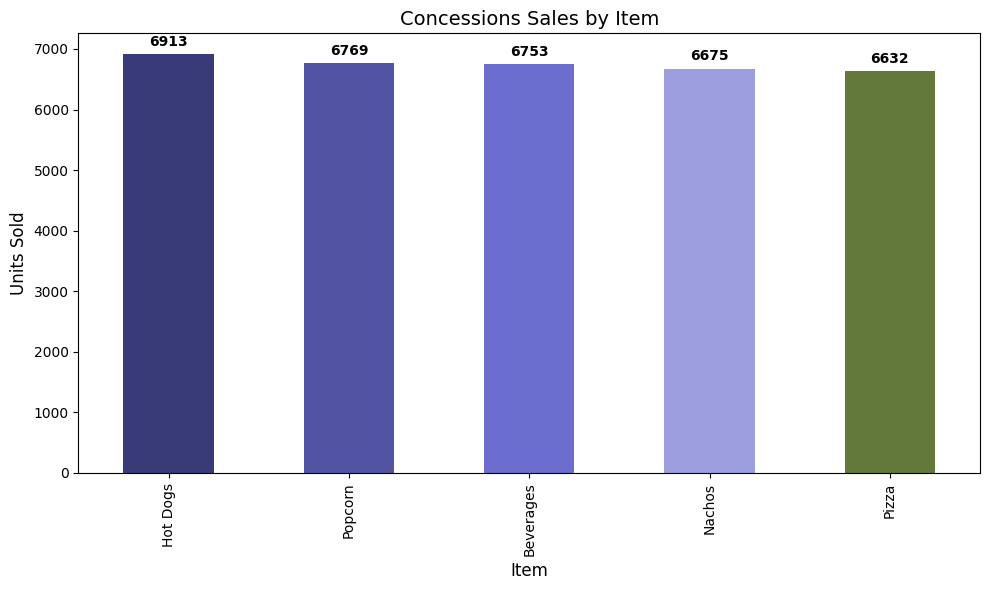

In [44]:
# Concessions: Total Sales by Item
concessions_sales = concessions_df["details"].apply(lambda x: x["stand_sales"])
total_concessions_sales = pd.DataFrame(concessions_sales.tolist()).sum()

# Sort the data
sorted_sales = total_concessions_sales.sort_values(ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = sorted_sales.plot(kind="bar", color=plt.cm.tab20b.colors, ax=ax)

# Add numbers on top of the bars
for i, v in enumerate(sorted_sales):
    ax.text(i, v + (max(sorted_sales)*0.02), # Slightly above each bar
            f"{int(v)}", # Format as integer
            ha='center', 
            fontweight='bold')

plt.title("Concessions Sales by Item", fontsize=14)
plt.xlabel("Item", fontsize=12)
plt.ylabel("Units Sold", fontsize=12)
plt.tight_layout()
plt.show()